## CCIS Analytics Hackathon 
BombSquad (Original Name: Group O)
1. Kolla Ananta Raj - IIT Kharagpur
2. Gurugubelli Ravi Kiran - IIT Kanpur

## Import Libraries

In [16]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

## Model

In [17]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Activation
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Flatten, Activation, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Concatenate, Add, Multiply, Lambda
from tensorflow.keras.layers import UpSampling2D, Reshape
from tensorflow.keras.layers import add,concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM,GRU

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

def Model():
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32,128,1))
    
    drop_out_rate = 0.4
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model)
    
    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)
    
    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape=((64,-1)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)
    
    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(len(char_list)+1, kernel_initializer='he_normal',name='dense2')(model) 
    outputs = Activation('softmax', name='softmax')(model)

    # model to be used at test time
    act_model = Model(inputs, outputs)
    
    return act_model,outputs,inputs

act_model,outputs,inputs=Model()

In [18]:
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
filepath='/kaggle/input/jhmhjm/adamo-100e-57924t-19287v.hdf5'
# load the saved best model weights
act_model.load_weights(filepath)

In [19]:
# Pre-processing image
def process_image(img):

    w, h = img.shape
        
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

# predict text from given array of images
def predict_text(images, model):
    
    prediction = model.predict(images)
    
    # use CTC decoder
    decoded = K.ctc_decode(prediction,   
                           input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                           greedy=True)[0][0]

    out = K.get_value(decoded)
    predicted_labels = []
    for i, x in enumerate(out):
        s = ''
        for p in x:
            if int(p) != -1:
                s = s+char_list[int(p)]
        predicted_labels.append(s)
        print("predicted text = ", s)
        plt.imshow(images[i].reshape(32,128), cmap=plt.cm.gray)
        plt.show()
        print('\n')

In [20]:
images_path = ['/kaggle/input/iam-dataset/IAM/words/a01/a01-000u/a01-000u-00-00.png',
       '/kaggle/input/iam-dataset/IAM/words/a01/a01-000u/a01-000u-00-03.png',
       '/kaggle/input/iam-dataset/IAM/words/a01/a01-000u/a01-000u-00-04.png',
       '/kaggle/input/iam-dataset/IAM/words/a01/a01-000u/a01-000u-01-02.png',
       '/kaggle/input/iam-dataset/IAM/words/a01/a01-000u/a01-000u-01-05.png']
images = [process_image(cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)) for im_path in images_path]
images = np.asarray(images)

predicted text =  A


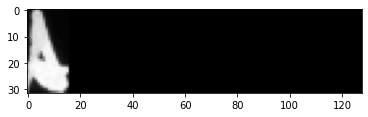



predicted text =  stop


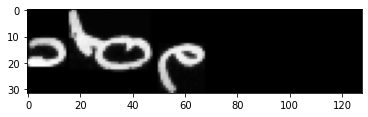



predicted text =  Mr.


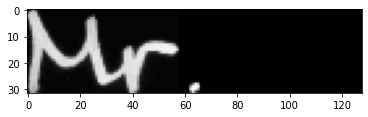



predicted text =  more


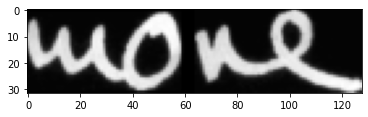



predicted text =  Peer


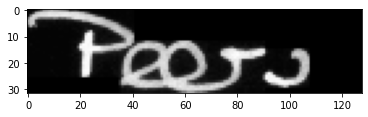



Time per images in s =  0.21082634925842286


In [26]:
import time
start = time.time()
predict_text(images, act_model)
print('Time per images in s = ',(time.time()-start)/images.shape[0])